# Introduction to the human metabolic reconstruction and FBA and FVA

<p>**Authors**: Thierry D.G.A Mondeel, Stefania Astrologo, Ewelina Weglarz-Tomczak & Hans V. Westerhoff <br/>
University of Amsterdam <br/>2017
</p>

**Note:** Some of the material in this tutorial is inspired by and adapted from the cell factory design course from The Novo Nordisk Foundation Center for Biosustainability https://biosustain.github.io/cell-factory-design-course/

**Questions**
- How do I explore the content (metabolites, reactions, genes, …) in a model?
- How do I perform flux balance analysis?
- What kind of questions can I answer by performing FBA experiments?

**Objectives**
- Understand the basic data structures of models.
- Set a biological objective and simulate a model.
- Manipulate bounds for defining media conditions and knocking out reactions

## Refresher: the human metabolic reconstruction: RECON 2

See the publication: http://doi.org/10.1038/nbt.2488

<span style="color:red">**Assignment (5 min):**</span> To refresh your memory of the lecture read the abstract and the first paragraph of the introduction of this paper.

## Loading the model
This cell loads the COBRA python module and load the human metabolic reconstruction. The specifics of the code do not matter. Just execute this this cell. 

In [65]:
import cobra
from cobra.flux_analysis import pfba
import pandas as pd # for tables
pd.set_option('display.max_colwidth', -1) # don't constrain the content of the tables

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('models/recon_2_2_simple_medium.json')
model = M.copy() # this way we can edit model but leave M unaltered

## Model components
Above we loaded the human metabolic reconstruction model. You can think of this model as having two key components:
1. The metabolic network of metabolites that are connected through reactions catalyzed by enzymes. This is captured mathematically as the "stoichiometry matrix".
2. Coupling of reactions to an identifier for the gene(s) that encode the enzyme catalyzing the reaction. 

As a consequence these models allow you to investigate the contents of the network and perturb them by doing gene knockouts. Since the model contains the information linking a specific gene to the reactions its enzyme catalyzes it becomes possible to see how such knockouts interfere with the metabolic network.

In Python you can interact with the model through broadly 3 different kinds of object: metabolites, reactions and genes. We will look at these below.

### The stoichiometry matrix
The stoichiometry matrix **completely** defines the network. The model for the human metabolic network contains 5324 metabolites and roughly 7785 reactions. The stoichiometry matrix therefore has 5324 rows and 7785 columns. You can see that below in the image. A blue dot in a certain row & column means that the metabolite that row refers to partakes in the reaction that column refers to. 

If metabolite number 5 is involved in reaction 99 with a stoichiometry coefficient of -1 (i.e. it is a substrate) in that reaction, then the stoichiometry matrix will have the value -1 in the rows 5 column 99. 

One metabolite like g3p maybe engages in 10 reactions or so. Whereas ATP might engage in hundreds of reactions. However, no metabolite gets even close to 7000 reactions. As a consequence the stoichiometry matrix mostly consists of zeros. 

In [112]:
S = model.copy().to_array_based_model().S.todense()
S

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

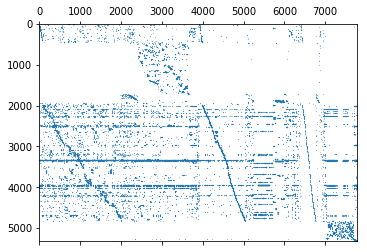

In [114]:
import matplotlib.pyplot as plt
plt.spy(S, precision=0.01, markersize=.1)
plt.show()

### Metabolites
The model contains a list of metabolites. Here are the first ten.

In [42]:
model.metabolites[0:10]

[<Metabolite 10fthf5glu_c at 0x112c09c50>,
 <Metabolite 10fthf5glu_e at 0x112c094e0>,
 <Metabolite 10fthf5glu_l at 0x112c09320>,
 <Metabolite 10fthf5glu_m at 0x112c09438>,
 <Metabolite 10fthf6glu_c at 0x112c09208>,
 <Metabolite 10fthf6glu_e at 0x112c09550>,
 <Metabolite 10fthf6glu_l at 0x112c09b00>,
 <Metabolite 10fthf6glu_m at 0x112c09940>,
 <Metabolite 10fthf7glu_c at 0x112c097f0>,
 <Metabolite 10fthf7glu_e at 0x112c09a58>]

How many metabolites are there?

In [43]:
len(model.metabolites)

5324

One can access a specific metabolite using dot notation.

In [47]:
model.metabolites.atp_c

<Metabolite atp_c at 0x116281390>

**Warning:** One cannot use dot notation to access metabolites, reactions, or genes if their identifiers do not resemble proper Python variable names.

In [48]:
model.metabolites.10fthf_c

SyntaxError: invalid syntax (<ipython-input-48-2772b042e9ed>, line 1)

**Solution:** Use the method `get_by_id` instead!


In [49]:
model.metabolites.get_by_id('10fthf_c')

<Metabolite 10fthf_c at 0x112c099e8>

Metabolites are associated with compartments in the cell. Glyceraldehyde 3-phosphate (g3p_c) is associated with the c (Cytosol) compartment.


In [51]:
model.metabolites.g3p_c.compartment

'c'

The reactions in the human metabolic reconstruction are categorized in various compartments. 

In [29]:
model.compartments

{'b': 'boundary',
 'c': 'cytoplasm',
 'e': 'extracellular space',
 'g': 'Golgi apparatus',
 'i': 'mitochondrial intermembrane space',
 'l': 'lysosome',
 'm': 'mitochondrion',
 'n': 'nucleus',
 'r': 'endoplasmic reticulum',
 'x': 'peroxisome'}

<span style="color:red">**Assignment (3 min):**</span> Do you know the biological role of all these compartments?

See here for more information: http://www.ncbi.nlm.nih.gov/books/NBK26907/

Some metabolites (like Glucose for example) can be associated with multiple compartments.

In [67]:
model.metabolites.glc_D_c.compartment
model.metabolites.glc_D_g.compartment

'c'

'g'

The full name of the metabolite is available via the .name attribute.

In [58]:
model.metabolites.glc_D_c.name

'D-glucopyranose'

One can look up the molecular formula of glucose and its weight.

The .elements attribute returns a dictionary representation of the formula.

In [106]:
model.metabolites.glc_D_c.formula
model.metabolites.glc_D_c.formula_weight

model.metabolites.g3p_c.elements

'C6H12O6'

180.15588

{'C': 3, 'H': 5, 'O': 6, 'P': 1}

Metabolites are not isolated things. They participate in reactions as substrates and products.



In [69]:
model.metabolites.g3p_c.reactions

frozenset({<Reaction TKT2 at 0x11cde0400>,
           <Reaction TRIOK at 0x11cde0828>,
           <Reaction TPI at 0x11cde0668>,
           <Reaction GAPD at 0x11cd8c898>,
           <Reaction DRPA at 0x11cd76b38>,
           <Reaction TALA at 0x11cddaf98>,
           <Reaction TKT1 at 0x11cde03c8>,
           <Reaction MGSA2 at 0x11cda89e8>,
           <Reaction FBA at 0x11cd817f0>})

If you are not sure which ID the metabolite you are looking has, you can use a query to look for it. Suppose we want to find lactate

In [115]:
for metabolite in model.metabolites.query('lactate','name'):
    print(metabolite.id, metabolite.name,metabolite.compartment)

34hpl_m 3-(4-hydroxyphenyl)lactate m
CE7218_c S-[2-carboxy-1-(1H-imidazol-4-yl)ethyl]-3-thiolactate c
lac_D_c (R)-lactate c
lac_D_e (R)-lactate e
lac_D_m (R)-lactate m
lac_L_c (S)-lactate c
lac_L_e (S)-lactate e
lac_L_m (S)-lactate m
lac_L_x (S)-lactate x
mercplaccys_c 3-mercaptolactate-cysteine disulfide c
mercplaccys_e 3-mercaptolactate-cysteine disulfide e
sl_L_c (S)-3-sulfonatolactate(2-) c
sl_L_e (S)-3-sulfonatolactate(2-) e
sl_L_m (S)-3-sulfonatolactate(2-) m


### Reactions
Reactions have similar properties as metabolites

How many metabolites are there?

In [73]:
len(model.reactions)

7785

In [118]:
for reaction in model.reactions[1000:1010]:
    print(reaction.id,reaction.name)

HEX4 hexokinase (D-mannose:ATP)
HEX7 hexokinase (D-fructose:ATP)
HEXCCPT1 carnitine O-palmitoyltransferase
HEXCCPT2 carnitine transferase
HGNTOR Homogentisate:oxygen 1,2-oxidoreductase (decyclizing)
HIBDm 3-hydroxyisobutyrate dehydrogenase, mitochondrial
HISD histidase
HISDC histidine decarboxylase
HISTASE Histaminase
HKYNH 3-Hydroxy-L-kynurenine hydrolase


Let's take a closer look at the reactions associated with Glyceraldehyde 3-phosphate (g3p). Reactions like metabolites have both a short ID, a longer name attribute and an attribute called reaction that contains the chemical reactions equation. Lets see all of these for the reactions g3p engages in.

In [119]:
for reaction in model.metabolites.g3p_c.reactions:
    print(reaction.id, reaction.name, reaction.reaction)

TKT2 transketolase e4p_c + xu5p_D_c <=> f6p_c + g3p_c Pentose phosphate pathway
TRIOK triokinase atp_c + glyald_c --> adp_c + g3p_c + h_c Fructose and mannose metabolism
TPI triose-phosphate isomerase dhap_c <=> g3p_c Glycolysis/gluconeogenesis
GAPD glyceraldehyde-3-phosphate dehydrogenase g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c Glycolysis/gluconeogenesis
DRPA deoxyribose-phosphate aldolase 2dr5p_c --> acald_c + g3p_c Pentose phosphate pathway
TALA transaldolase g3p_c + s7p_c <=> e4p_c + f6p_c Pentose phosphate pathway
TKT1 transketolase r5p_c + xu5p_D_c <=> g3p_c + s7p_c Pentose phosphate pathway
MGSA2 methyglyoxylate synthase 2 (from g3p) g3p_c --> mthgxl_c + pi_c Pyruvate metabolism
FBA fructose-bisphosphate aldolase fdp_c <=> dhap_c + g3p_c Glycolysis/gluconeogenesis


<span style="color:red">**Assignment (3 min):**</span> In the cell above try to also add the "subsystem" attribute of the reactions to the print statement. You may find this under reaction.subsystem. 

This will give you some more clarity on the pathway these reactions function in.

#### Reaction bounds
In constraint-based (FBA) models reactions are associated with two bounds, a lower bound and an upper bound. These constrain the amount of flux that is allowed to run through a certain reaction. 

The most important way these are used is to take into account thermodynamics of reactions. If a certain reaction has a very high **negative** $\Delta G^{'0}$ then this reaction is practically irreversible. As such its lower bound is often made zero, meaning that the flux cannot run in the backward direction because it goes against thermodynamics. This makes the model predictions more realistic.

##### If you need a refresher on thermodynamics 
This page has all you need to know: https://www.khanacademy.org/science/chemistry/thermodynamics-chemistry/gibbs-free-energy/a/gibbs-free-energy-and-spontaneity

Let's look at an example: pyruvate kinase has a lower bound of zero in our model.

In [138]:
model.reactions.PYK.name
model.reactions.PYK.reaction
model.reactions.PYK.bounds

'pyruvate kinase'

'adp_c + h_c + pep_c --> atp_c + pyr_c'

(0.0, 1000)

<span style="color:red">**Assignment (3 min):**</span> Check that this makes sense thermodynamically. Go to: http://equilibrator.weizmann.ac.il/ and type in "pyruvate kinase". Click the reaction corresponding to the one above.

Look at the estimates for the $\Delta G^{'0}$. Does this match with the model? 

### Genes and their link to reactions
Remember that the core of the model is made up of the stoichiometry matrix which links metabolites and reactions. The second layer of the model consists of gene coupling to reactions. 

In [83]:
len(model.genes)

1675

<span style="color:red">**Assignment (1 min):**</span> Why is this such a small number? What about all the other human genes? How many genes do human actually have in total? 

See: http://doi.org/10.1126/science.1058040


Glyceraldehyde-3-phosphate dehydrogenase is associated with two genes.

In [97]:
model.reactions.GAPD.gene_reaction_rule

'HGNC:24864 or HGNC:4141'

These gene identifiers refer to the Hugo Gene Nomenclature Committee database: http://www.genenames.org/cgi-bin/gene_symbol_report?hgnc_id=4141

<span style="color:red">**Assignment (3 min):**</span> Is this annotated correctly. Why two genes?

Here a very complicated gene to reaction mapping (ATP synthase).

In [121]:
model.reactions.ATPS4m.name
model.reactions.ATPS4m.reaction
model.reactions.ATPS4m.gene_reaction_rule

'ATP synthase (four protons for one ATP)'

'adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m'

'(HGNC:13213 and HGNC:14247 and HGNC:18799 and HGNC:8016 and HGNC:823 and HGNC:830 and HGNC:833 and HGNC:837 and HGNC:838 and HGNC:840 and HGNC:842 and HGNC:845 and HGNC:846 and HGNC:847 and HGNC:848 and HGNC:850) or (HGNC:14247 and HGNC:8016 and HGNC:823 and HGNC:830 and HGNC:833 and HGNC:837 and HGNC:838 and HGNC:840 and HGNC:841 and HGNC:845 and HGNC:846 and HGNC:847 and HGNC:848) or (HGNC:14247 and HGNC:8016 and HGNC:823 and HGNC:830 and HGNC:833 and HGNC:837 and HGNC:838 and HGNC:840 and HGNC:842 and HGNC:845 and HGNC:846 and HGNC:847 and HGNC:848) or (HGNC:14247 and HGNC:8016 and HGNC:823 and HGNC:830 and HGNC:833 and HGNC:837 and HGNC:838 and HGNC:840 and HGNC:843 and HGNC:845 and HGNC:846 and HGNC:847 and HGNC:848)'

### The medium
The next key component of the model is the "medium", i.e. the set of metabolites that is allowed to be taken up into the cell. For human cells this should entail the essential amino acids, glucose, oxygen etc. The way this is done in the model is by having so-called "exchange reactions" that transport such a metabolite into the extracellular space (the "e" compartment we came across above). Typically each of these reactions start with 'EX_' which stands for exchange reaction. The word exchange refers to the fact that this is an exchange of metabolites with the environment or the biofluids surrounding the cell. 

Exchange reactions are defined as: X <=> . So a negative (to the left) flux means uptake of metabolite X. Positive (to the right) flux would mean X is produced by the cell. This would typically be the case for lactate or CO2 etc. 

<span style="color:red">**Assignment (3 min):**</span> Make sure you understand the difference between an exchange reaction and a transport reaction. They are not the same thing!

Exchange $$X <=> $$ Transport $$ X_c <=> X_e$$

Below we print the medium of the model. The table shows the bound on each such inward flux.

In [28]:
pd.DataFrame(list(model.medium.items()),columns=['Reaction','Inward flux']).set_index('Reaction')

,Inward flux
Reaction,
EX_thr_L_e,0.1
EX_met_L_e,0.1
EX_val_L_e,0.1
EX_ile_L_e,0.1
EX_glc_e,1.0
EX_o2_e,1000.0
EX_nh4_e,1000.0
EX_his_L_e,0.1
EX_leu_L_e,0.1


You may ignore the biomass_other reaction.

<span style="color:red">**Assignment (3 min):**</span>Would you say this is a reasonable medium for a human cell to live in?

## Performing Flux Balance Analysis

### What is FBA again?
We will use the constraint-based modeling technique called flux balance analysis (FBA) (http://doi.org/10.1038/nbt.1614). Given the metabolic network this method computationally calculates the flux distribution, meaning the fluxes through all reactions in the model at steady-state, that is optimal according to a specified objective function. In our case, the objective function will usually be the flux through the biomass reaction. This reaction contains (when known) experimentally determined ratio's of metabolites that make of the composition of a cell.

FBA has traditionally been applied to metabolism as we are doing here. FBA primarily makes use of the stoichiometry matrix $S$. This matrix is of size $m \times r$ where $m$ is the number of species or metabolites in the system and $r$ is the number of reactions. Every row of $S$ specifies for a specific metabolite in what quantity it partakes in each reaction. Therefore, each element $(i,j)$ of $S$ contains the stoichiometric coefficient of metabolite $i$ in reaction $j$.

The word flux is used to describe a reaction rate at steady state. In FBA the aim is to find the flux distributions of the network that satisfy (1) the steady-state condition, this is based on the assumption that metabolism occurs on a fast time-scale compared to gene regulatory events and thus reaction rates are constant, (2) thermodynamic feasibility , i.e. some reactions are known to be irreversible, (3) maximal flux constraints when these are known and (4) maximize some objective like growth. 

### For the brave
Mathematically, this can be concisely summarized as
\begin{align*}
\text{Maximize } Z &=c^T v, \text{ such that } \\
Sv &= 0 \\
\alpha_k \leq & ~ v_k \leq \beta_k, \text{ for all k}.
\end{align*}
Here $Z$ is the objective, $v$ is the vector of fluxes representing all reactions in the model, $S$ is the stoichiometry matrix, $\alpha_k$ is the lower bound for reaction $k$ and similarly $\beta_k$ is the upper bound for reaction $k$.

This can be thought of as first constraining all possible solutions to the ones that allow a steady state and satisfy the bounds ( this results in a multi dimensional cone within the null space of S) and then finding the optimal solution among the remaining degrees of freedom.

### What you will do
We will perform in-silico experiments with genetic manipulations by changing the third line in the above equation, i.e. the lower and upper bounds for the reactions. By setting both the lower bound $\alpha_k$ and the upper bound $\beta_k$ to zero we in effect knock out a reaction. Similarly, by setting it to a specific value we can fix a certain flux level for a specific reaction.

### What is our in-silico cell optimizing? 
Let us first check what objective is set for our model.

In [34]:
model.objective.expression

1.0*biomass_reaction - 1.0*biomass_reaction_reverse_32a6c

So the objective is biomass. Don't get confused by the subtraction of biomass_reaction_reverse. The details do not matter now, but internally the two directions are handled separately and if the flux is "reversed" with a flux of 5 you would want the objective score to be -5. That is why it is subtracted. 

<span style="color:red">**Assignment (5 min):**</span> Is optimal growth a realistic assumption for human cells? For bacterial cells? Discuss... 

### Doing FBA is simple...
Actually performing FBA with cobrapy once you have loaded a model is really easy and fast. 

In [125]:
solution = model.optimize()

"solution" now contains the result of our simulation. Let's see what we can do with this. The most important attributes here are:
- status => did we find an optimial solution?
- objective_value => what is the biomass flux?
- fluxes => the flux through every reaction in the model solution

In [128]:
solution.status
solution.objective_value
solution.fluxes['GAPD']

'optimal'

0.1688875377885865

1.7276112151972336

A very nice summary of what goes in and out of the cell in this solution can be gotten with the summary attribute of the model object.

In [129]:
model.summary()

IN FLUXES                 OUT FLUXES       OBJECTIVES
------------------------  ---------------  ----------------------
o2_e             1.9      h2o_e    2.79    biomass_reac...  0.169
glc_D_e          1        co2_e    2.09
nh4_e            0.5      h_e      0.968
pi_e             0.21     lac_D_e  0.347
his_L_e          0.1      so4_e    0.0663
ile_L_e          0.1      anth_c   0.065
leu_L_e          0.1      bhb_e    0.0292
lys_L_e          0.1
met_L_e          0.1
phe_L_e          0.1
thr_L_e          0.1
val_L_e          0.1
trp_L_e          0.0801
biomass_other_c  0.00912


<span style="color:red">**Assignment (3 min):**</span> Investigate the metabolites that are produced (i.e. in the OUT FLUXES column). Are these what you would have expected? 

<span style="color:red">**Assignment (5 min):**</span> What would happen if we force the cell to produce something else than lactate? Try this by setting the **upper_bound** of the exchange reaction of lactate 'EX_lac_D_e' to zero. Then rerun model.optimize() and look at the model.summary() again. 

What new products have been produced? Did the growth rate remain the same? 

If you want repeat this process a couple times. Be sure to block multiple metabolites simultaneously.

In [150]:
model.reactions.DM_anth.upper_bound = 0
model.reactions.EX_lac_D_e.upper_bound = 0
model.reactions..upper_bound = 0


model.optimize()
model.summary()

<Solution 0.169 at 0x13084afd0>

IN FLUXES                 OUT FLUXES             OBJECTIVES
------------------------  ---------------------  ----------------------
o2_e             2.15     h2o_e         3.37     biomass_reac...  0.169
glc_D_e          1        co2_e         2.53
nh4_e            0.617    h_e           0.66
pi_e             0.216    so4_e         0.0663
his_L_e          0.1      citr_L_c      0.0325
ile_L_e          0.1      bhb_e         0.0292
leu_L_e          0.1      pchol_hs_e    0.00646
lys_L_e          0.1      xolest2_hs_e  0.00543
met_L_e          0.1      urate_e       0.00346
phe_L_e          0.1
thr_L_e          0.1
val_L_e          0.1
trp_L_e          0.0476
biomass_other_c  0.00912


In [144]:
model.metabolites.biomass_other_c.reactions

frozenset({<Reaction biomass_reaction at 0x11f571908>,
           <Reaction biomass_other at 0x11f571ac8>})

## Parsimonious enzyme-usage flux balance analysis (pFBA)

In [36]:
sol = pfba(model)
print('Solution status: {}'.format(sol.status))
print('Objective value: {}'.format(sol.fluxes['biomass_reaction']))

Solution status: optimal
Objective value: 0.1688875377885865


### Assignment
Write a list comprehension in the cell below that calculates the total flux, i.e. the sum of all fluxes. We already added the print command for you.

You can check that you did it right by asking for the value of sol.objective_value

In [ ]:
total_flux = sum([]) # write a list comprehension here, make use of sol.data_frame.flux
# make sure you take the absolute value of the flux (use abs()) so that negative fluxes (going in the backward direction) 
# are not reducing the total flux value
print 'Total flux: {}'.format(total_flux)

### Are essential amino acids essential?

We will now look into which reactions the model predicts to be essential for growth. 

### Assignment method 1: look at the output of pFBA.
Use the cell below to print all non-zero flux values. Try to look at the exchange reactions (starting with "EX_") in particular. They represent what medium components were used. Are all 9 essential amino acids actually predicted to be needed by the model?

In [37]:
fbaTable = pd.DataFrame( { 'Name' : list( model.reactions ),
                'Lb' : [model.reactions[i].lower_bound for i in range(len(model.reactions)) ],
                'Ub' : [model.reactions[i].upper_bound for i in range(len(model.reactions)) ],
                'Flux' : model.solution.x  } )
fbaTable = fbaTable[['Name','Flux','Lb','Ub']]
fbaTable[abs(fbaTable.Flux) > 0]

AttributeError: 'Model' object has no attribute 'solution'

### Assignment Method 2: Calculating the essential genes using flux variability analysis
This is built-in in cameo under the model.essential_reactions() function. See the code cell below.

Are the "essential" amino acids predicted to be essential?

Compare the number of essential reactions predicted here, with the number of reactions you got when doing pFBA? 
Why did pFBA give you more reactions?

In [ ]:
model = M.copy()
ess_rxns = model.essential_reactions()

print '{} reactions are essential for growth\n\n'.format(len(ess_rxns))

fbaTable = pd.DataFrame( { 'ID' : [rxn.id for rxn in ess_rxns],
                'Name' : [rxn.name for rxn in ess_rxns],
                'Reaction' : [rxn.reaction for rxn in ess_rxns]  } )
fbaTable[['ID','Name','Reaction']]

## Self-check questions
Make sure you are able to explain in your own words: 
1. What the two core components of the human metabolic reconstruction model are
2. How the thermodynamics is taken into account in the reaction bounds
3. what flux balance analysis is
4. What FBA actually computates
5. How FVA is different from FBA 